# Traditional Models

For: Tan Cheen Hao!!!

The idea for this file is to train multiple traditional models given the dataset. The data files you will need to import is unfortunately not ready. But for now, write and test the code using `model_building_data.csv` which is provided in the data folder. Keep in mind that the final training/testing files will have more fields.

You should test out everything you can think of. Focus on regression models but some classification models could be useful during stacking (up or down prediction rather than the exact value).

Also, these models will not be timeseries models. Therefore, you will need to engineer lagged parameters to make use of the timeseries nature.

Some models will be use during the stacking process. If not then it will be use as benchmark models. Everything will be included in the report so the more the better. Keep in mind that different models will require a different processing pipeline. This is because some models can take care of missing data, some cant. Some models are more sensitive to data ranges. Use GPT to check how to process for each! A useful tip is if you can generalise a preprocessing function for every model, then your life will be a lot easier.

Last thing to keep in mind is, some rows might have missing revenue but non-missing CAR etc. If you will drop NaNs, drop for each y values differently to prevent unnecessary data loss.

Tune all parameters for all models using 3-fold CV with the timesplit function like in assignment 1. I'll write a different time split function and we'll run with 5-10 fold CV again later before submission.

This file should save the output of the prediction in the format:

| ticker | quarter_year  | log_revenue_prediction_svm_regres | CAR_prediction_svm_regres | log_revenue_prediction_linear_regres | CAR_prediction_linear_regres |
|--------|---------------|-----------------------------------|---------------------------|--------------------------------------|------------------------------|
| BAC    | Q1 2001       | 123                               | 0.5                       | 123                                  | 0.5                          |
| JPM    | Q1 2001       | 456                               | 0.8                       | 456                                  | 0.8                          |
| WFC    | Q1 2001       | 789                               | 0.25                      | 789                                  | 0.25                         |

Enjoy!


Processing target column: car5
Loading data from data/train_data_CAR5_with_text.csv and data/test_data_CAR5_with_text.csv...

Preprocessing data...

Training and evaluating models for target: car5
Using OOF predictions: True, Folds: 5, Time series CV: False

Training linear for car5...
  Training fold 1/5...
    Fold 1 RMSE: 0.0569
  Training fold 2/5...
    Fold 2 RMSE: 0.0574
  Training fold 3/5...
    Fold 3 RMSE: 0.0562
  Training fold 4/5...
    Fold 4 RMSE: 0.0540
  Training fold 5/5...
    Fold 5 RMSE: 0.0557
  Mean OOF RMSE: 0.0560
  Train RMSE: 0.0558, R²: 0.0449
  OOF RMSE: 0.0560, R²: 0.0349
  Test RMSE: 0.0602, R²: -0.0123

Training ridge for car5...
  Training fold 1/5...
    Fold 1 RMSE: 0.0569
  Training fold 2/5...
    Fold 2 RMSE: 0.0574
  Training fold 3/5...
    Fold 3 RMSE: 0.0562
  Training fold 4/5...
    Fold 4 RMSE: 0.0540
  Training fold 5/5...
    Fold 5 RMSE: 0.0557
  Mean OOF RMSE: 0.0560
  Train RMSE: 0.0558, R²: 0.0449
  OOF RMSE: 0.0560, R²: 0.0349
  Tes

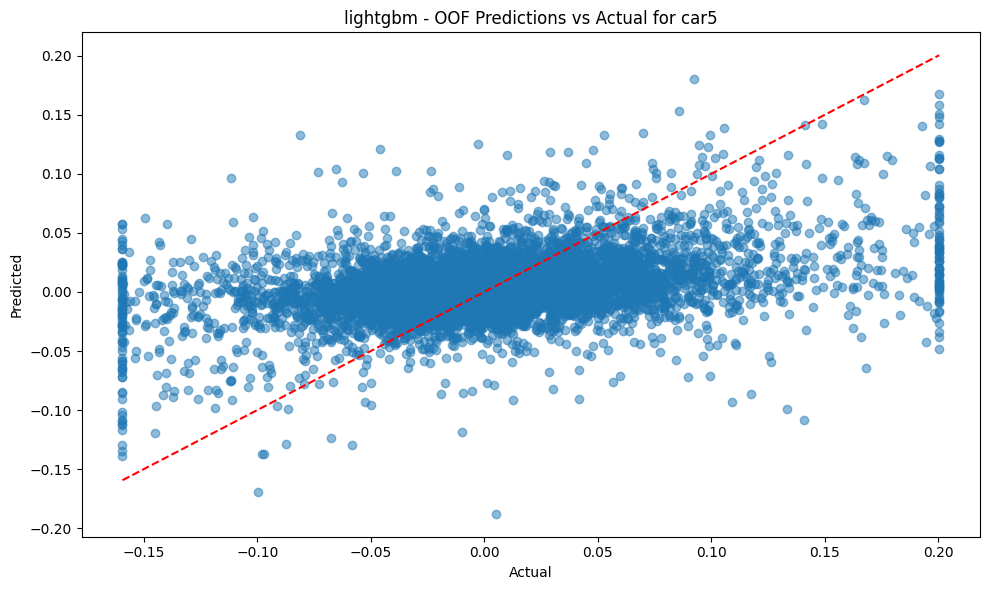

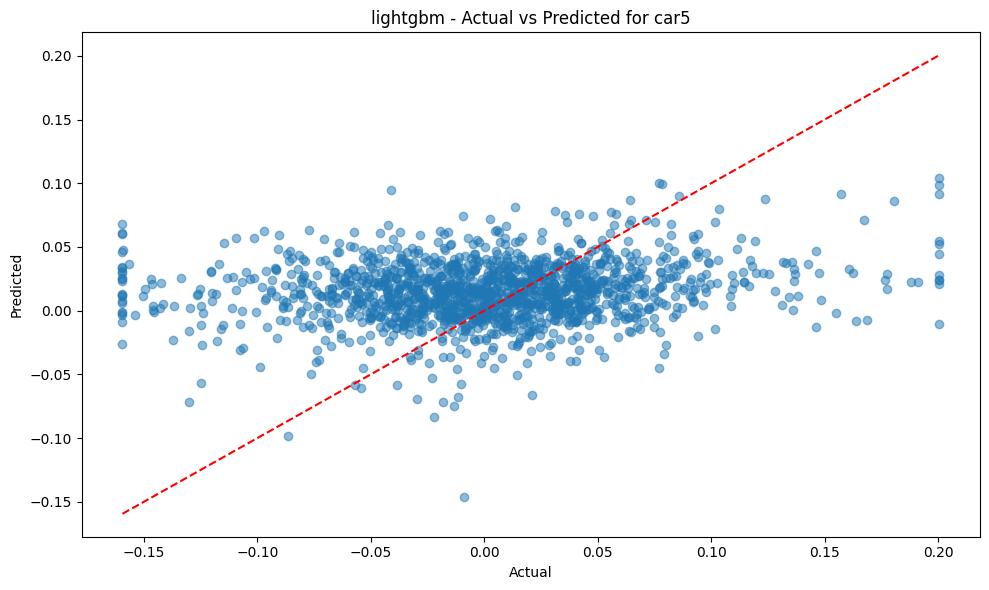

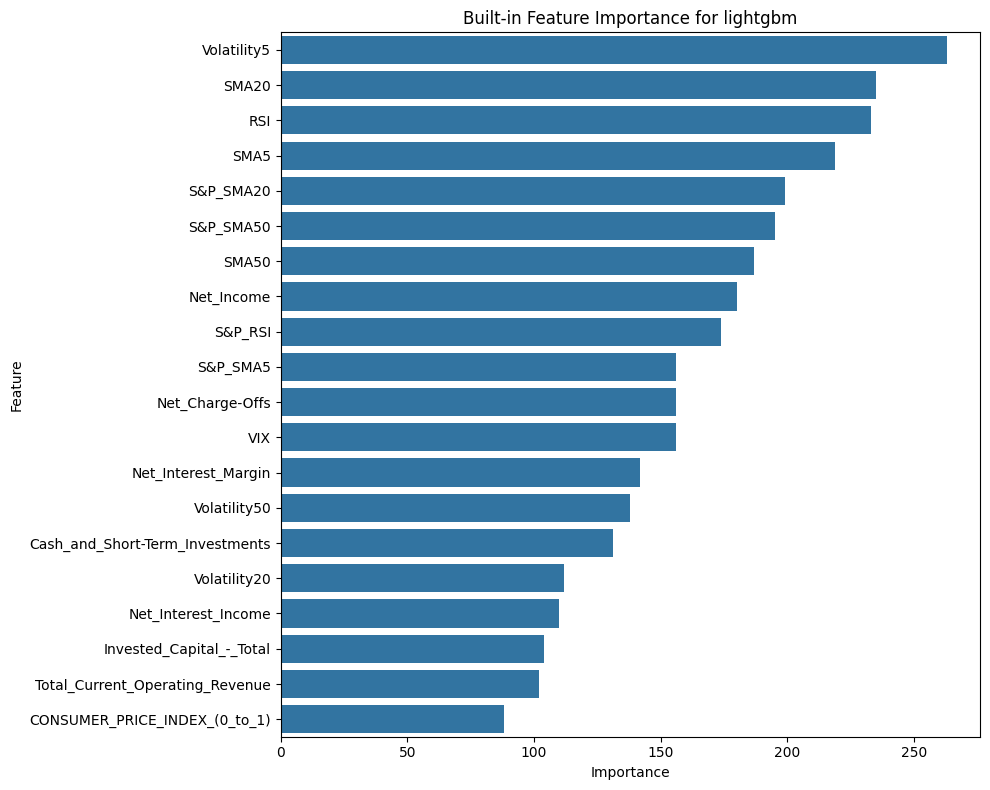


Processing target column: Total Current Operating Revenue
Loading data from data/train_data_REV_with_text.csv and data/test_data_REV_with_text.csv...

Preprocessing data...

Training and evaluating models for target: Total Current Operating Revenue
Using OOF predictions: True, Folds: 5, Time series CV: False

Training linear for Total Current Operating Revenue...
  Training fold 1/5...
    Fold 1 RMSE: 0.0299
  Training fold 2/5...
    Fold 2 RMSE: 0.0335
  Training fold 3/5...
    Fold 3 RMSE: 0.0292
  Training fold 4/5...
    Fold 4 RMSE: 0.0305
  Training fold 5/5...
    Fold 5 RMSE: 0.0297
  Mean OOF RMSE: 0.0306
  Train RMSE: 0.0303, R²: 0.9672
  OOF RMSE: 0.0306, R²: 0.9665
  Test RMSE: 5327246112.7966, R²: -952299849488453074944.0000

Training ridge for Total Current Operating Revenue...
  Training fold 1/5...
    Fold 1 RMSE: 0.0299
  Training fold 2/5...
    Fold 2 RMSE: 0.0335
  Training fold 3/5...
    Fold 3 RMSE: 0.0292
  Training fold 4/5...
    Fold 4 RMSE: 0.0305
  Tra

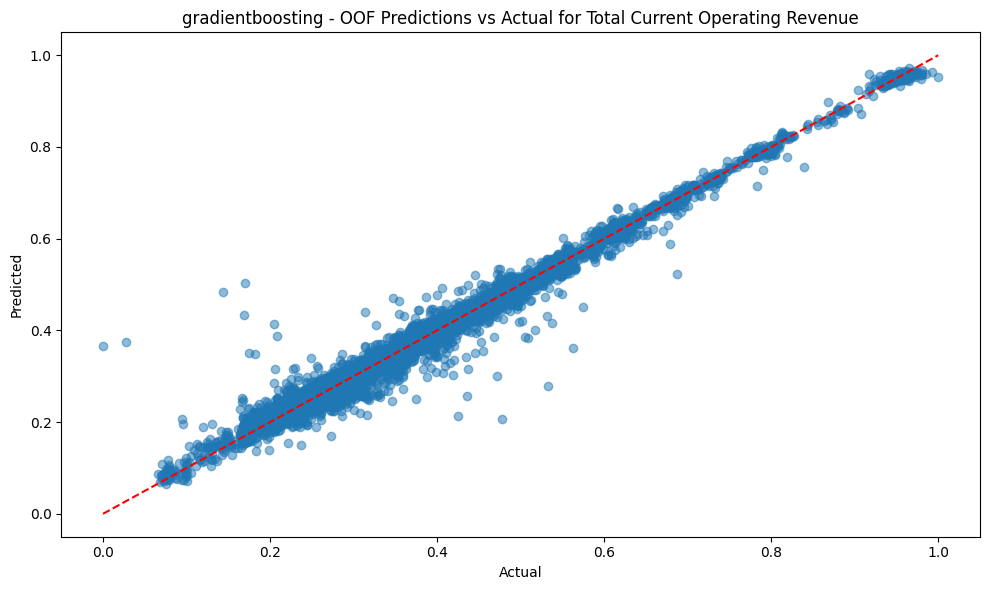

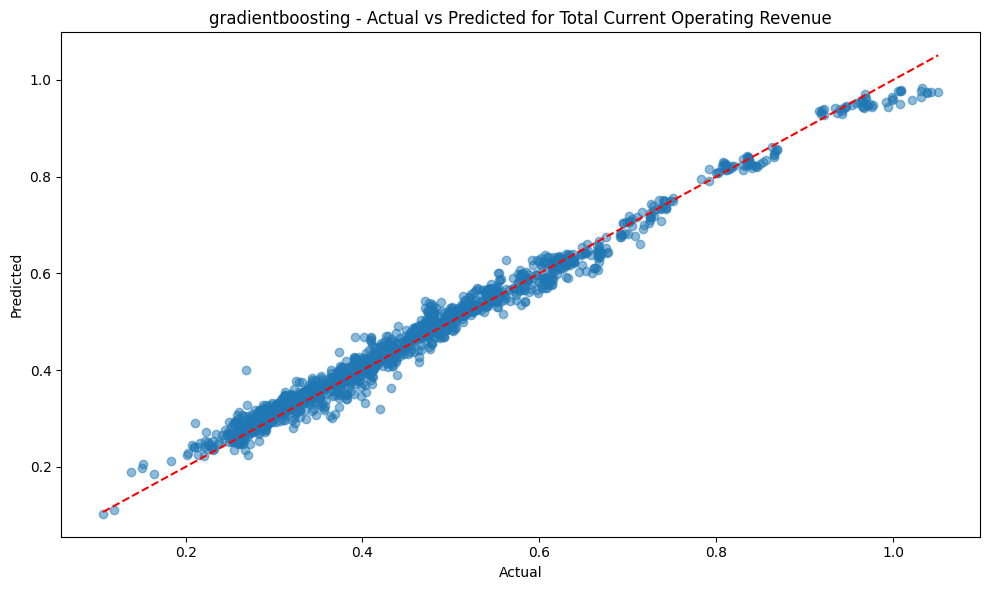

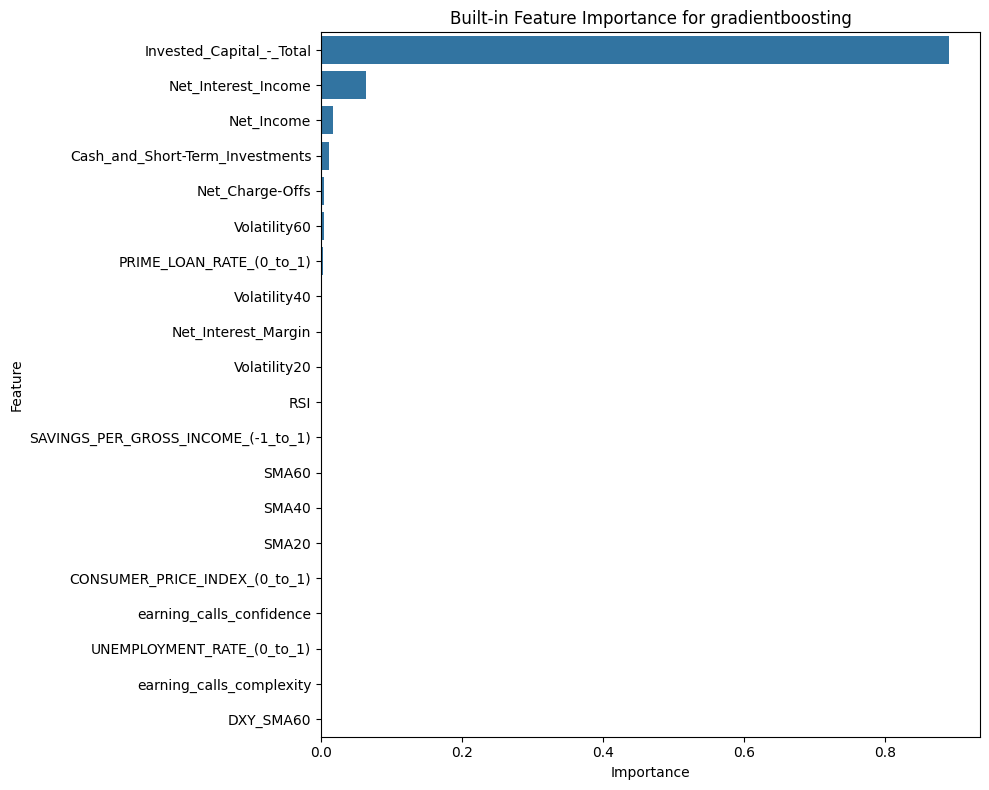


Comparison of Metrics Across Targets:
                            Target        Best Model  Test RMSE  Test MAE  \
0                             car5          lightgbm   0.061992  0.046969   
1  Total Current Operating Revenue  gradientboosting   0.021972  0.016899   

    Test R²  
0 -0.073963  
1  0.983800  

OOF predictions for car5:
   oof_linear_car5  oof_ridge_car5  oof_lasso_car5  oof_elasticnet_car5  \
0         0.010521        0.010524        0.005479             0.005479   
1         0.015382        0.015382        0.005270             0.005270   
2         0.004499        0.004509        0.005270             0.005270   
3         0.028324        0.028321        0.005052             0.005052   
4         0.003863        0.003869        0.005052             0.005052   

   oof_svr_car5  oof_knn_car5  oof_decisiontree_car5  oof_randomforest_car5  \
0      0.010796      0.000033               0.002591              -0.002056   
1     -0.003799     -0.005556              -0.00161

In [ ]:
# ===========================
# 1. Imports
# ===========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore') 

# ===========================
# 2. Load data
# ===========================
def load_data(train_filepath, test_filepath):
    """
    Load both training and test datasets
    """
    train_df = pd.read_csv(train_filepath)
    test_df = pd.read_csv(test_filepath)
    return train_df, test_df

# ===========================
# 3. Preprocess data
# ===========================
def preprocess_data(train_df, test_df, target_col):
    """
    Preprocess both training and test datasets
    - Handles missing values
    - Drops non-numeric columns
    - Applies scaling (fit on train, transform on both)
    """
    # Drop rows with missing target in training data
    train_df = train_df.dropna(subset=[target_col]).copy()
    
    # Split features and target
    X_train = train_df.drop(columns=[target_col])
    y_train = train_df[target_col]
    
    # Test data may or may not have the target column
    if target_col in test_df.columns:
        X_test = test_df.drop(columns=[target_col])
        y_test = test_df[target_col]
    else:
        X_test = test_df.copy()
        y_test = None
    
    # Select only numeric columns
    X_train = X_train.select_dtypes(include=[np.number])
    X_test = X_test.select_dtypes(include=[np.number])
    
    # Ensure both datasets have the same columns
    common_columns = list(set(X_train.columns) & set(X_test.columns))
    X_train = X_train[common_columns]
    X_test = X_test[common_columns]
    
    # Handle missing values by imputing with the mean (fit on train only)
    train_means = X_train.mean()
    X_train = X_train.fillna(train_means)
    X_test = X_test.fillna(train_means)
    
    # Scale features (fit on train only)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Sanitize feature names to remove special characters
    sanitized_columns = [col.replace(" ", "_").replace(":", "_").replace(",", "_") for col in X_train.columns]
    X_train = pd.DataFrame(X_train_scaled, columns=sanitized_columns, index=X_train.index)
    X_test = pd.DataFrame(X_test_scaled, columns=sanitized_columns, index=X_test.index)
    
    return X_train, y_train, X_test, y_test

# ===========================
# 4. Build model
# ===========================
def build_model(model_name, params=None):
    """
    Build a model with optional parameters
    """
    models = {
        'linear': LinearRegression(),
        'ridge': Ridge(),
        'lasso': Lasso(),
        'elasticnet': ElasticNet(),
        'svr': SVR(),
        'knn': KNeighborsRegressor(),
        'decisiontree': DecisionTreeRegressor(),
        'randomforest': RandomForestRegressor(),
        'gradientboosting': GradientBoostingRegressor(),
        'xgboost': xgb.XGBRegressor(objective='reg:squarederror'),
        'lightgbm': lgb.LGBMRegressor()
    }
    
    model = models.get(model_name)
    
    if params and model is not None:
        model.set_params(**params)
        
    return model

# ===========================
# 5. Best parameter configurations
# ===========================
def get_best_params(model_name):
    """
    Return pre-optimized parameters for each model
    These can be customized based on your specific dataset
    """
    best_params = {
        'linear': {},
        'ridge': {'alpha': 1.0},
        'lasso': {'alpha': 0.1},
        'elasticnet': {'alpha': 0.1, 'l1_ratio': 0.5},
        'svr': {'C': 1.0, 'epsilon': 0.1, 'kernel': 'rbf'},
        'knn': {'n_neighbors': 5, 'weights': 'uniform'},
        'decisiontree': {'max_depth': 5, 'min_samples_split': 5},
        'randomforest': {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 5},
        'gradientboosting': {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 5},
        'xgboost': {
            'n_estimators': 200, 
            'learning_rate': 0.1, 
            'max_depth': 5, 
            'subsample': 0.8, 
            'colsample_bytree': 0.8
        },
        'lightgbm': {
            'n_estimators': 200, 
            'learning_rate': 0.1, 
            'max_depth': 5, 
            'num_leaves': 31
        }
    }
    return best_params.get(model_name, {})

# ===========================
# 6. Train model with OOF predictions
# ===========================
def train_model_with_oof(X_train, y_train, model_name, params=None, n_folds=5, time_series=False):
    """
    Train a model with specified parameters and generate out-of-fold predictions
    
    Args:
        X_train: Training features
        y_train: Training target
        model_name: Name of the model to train
        params: Model parameters (if None, use best params)
        n_folds: Number of folds for cross-validation
        time_series: If True, use TimeSeriesSplit instead of KFold
        
    Returns:
        trained_model: Model trained on full dataset
        oof_preds: Out-of-fold predictions
        oof_scores: Cross-validation scores
    """
    if params is None:
        params = get_best_params(model_name)
    
    # Initialize cross-validation
    if time_series:
        cv = TimeSeriesSplit(n_splits=n_folds)
    else:
        cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # Initialize arrays for OOF predictions and indices
    oof_preds = np.zeros(len(X_train))
    oof_scores = []
    
    # Train model on each fold
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train)):
        print(f"  Training fold {fold+1}/{n_folds}...")
        
        # Split data
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Build and train model
        model = build_model(model_name, params)
        model.fit(X_fold_train, y_fold_train)
        
        # Make predictions on validation fold
        fold_preds = model.predict(X_fold_val)
        oof_preds[val_idx] = fold_preds
        
        # Calculate fold score
        fold_rmse = np.sqrt(mean_squared_error(y_fold_val, fold_preds))
        oof_scores.append(fold_rmse)
        print(f"    Fold {fold+1} RMSE: {fold_rmse:.4f}")
    
    # Calculate average OOF score
    mean_oof_rmse = np.mean(oof_scores)
    print(f"  Mean OOF RMSE: {mean_oof_rmse:.4f}")
    
    # Train final model on full dataset
    final_model = build_model(model_name, params)
    final_model.fit(X_train, y_train)
    
    return final_model, oof_preds, mean_oof_rmse

# Train a single model
def train_model(X_train, y_train, model_name, params=None):
    """
    Train a model with specified parameters on the full training dataset
    """
    if params is None:
        params = get_best_params(model_name)
        
    model = build_model(model_name, params)
    model.fit(X_train, y_train)
    return model

# ===========================
# 7. Evaluate model
# ===========================
def evaluate_model(model, X, y, dataset_name=""):
    """
    Evaluate model performance on given dataset
    
    Args:
        model: Trained model
        X: Features
        y: True target values
        dataset_name: Name of the dataset (for naming the metrics)
        
    Returns:
        results: Dictionary of evaluation metrics
        y_pred: Predicted values
    """
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    results = {
        f'{dataset_name} RMSE': rmse,
        f'{dataset_name} MAE': mae,
        f'{dataset_name} R2': r2
    }
    
    return results, y_pred

# ===========================
# 7b. Calculate feature importance
# ===========================
def calculate_permutation_importance(model, X, y, n_repeats=10, random_state=42):
    """
    Calculate permutation feature importance
    Works with any model type, not just tree-based models
    
    Args:
        model: Trained model
        X: Features
        y: True target values
        n_repeats: Number of times to permute each feature
        random_state: Random seed
        
    Returns:
        importance_df: DataFrame with feature importances
    """
    from sklearn.inspection import permutation_importance
    
    # Calculate permutation importance
    perm_importance = permutation_importance(
        model, X, y, n_repeats=n_repeats, random_state=random_state
    )
    
    # Create DataFrame for plotting
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': perm_importance.importances_mean,
        'Std': perm_importance.importances_std
    }).sort_values(by='Importance', ascending=False)
    
    return importance_df

# ===========================
# 8. Plot predictions
# ===========================
def plot_predictions(y_true, y_pred, model_name, target_col, plot_title=None):
    """
    Plot actual vs. predicted values
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    
    if plot_title is None:
        plot_title = f'{model_name} - Actual vs Predicted for {target_col}'
    plt.title(plot_title)
    
    plt.tight_layout()
    plt.show()

def plot_oof_predictions(y_train, oof_preds, model_name, target_col):
    """
    Plot out-of-fold predictions vs actual values
    """
    plot_predictions(
        y_train, oof_preds, model_name, target_col,
        plot_title=f'{model_name} - OOF Predictions vs Actual for {target_col}'
    )

# ===========================
# 9. Plot feature importance
# ===========================
def plot_feature_importance(model, X, model_name, y=None, top_n=20, use_permutation=False):
    """
    Plot feature importance for models
    
    Args:
        model: Trained model
        X: Features dataframe
        model_name: Name of the model
        y: Target values (needed for permutation importance)
        top_n: Number of top features to display
        use_permutation: Whether to use permutation importance instead of built-in
    """
    tree_based_models = ['decisiontree', 'randomforest', 'gradientboosting', 'xgboost', 'lightgbm']
    
    # Get feature importance
    if use_permutation and y is not None:
        # Use permutation importance (works with any model)
        print("Calculating permutation importance...")
        feature_importance = calculate_permutation_importance(model, X, y)
        importance_title = 'Permutation Feature Importance'
    elif model_name in tree_based_models:
        # Use built-in feature importance for tree-based models
        if model_name in ['xgboost', 'lightgbm'] or hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
            
            # Create DataFrame for plotting
            feature_importance = pd.DataFrame({
                'Feature': X.columns,
                'Importance': importance
            }).sort_values(by='Importance', ascending=False)
            
            importance_title = 'Built-in Feature Importance'
        else:
            print(f"Feature importance not directly available for {model_name}")
            return
    else:
        print(f"Feature importance not available for {model_name}")
        if y is not None:
            print("Consider using permutation importance with use_permutation=True")
        return
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance.head(top_n), x='Importance', y='Feature')
    plt.title(f'{importance_title} for {model_name}')
    plt.tight_layout()
    plt.show()
    
    return feature_importance

# ===========================
# 10. Train and evaluate all models with OOF predictions
# ===========================
def run_all_models(X_train, y_train, X_test, y_test, target_col, use_oof=True, n_folds=5, time_series=False):
    """
    Train and evaluate all models with optional OOF predictions
    
    Args:
        X_train: Training features
        y_train: Training target
        X_test: Test features
        y_test: Test target (can be None)
        target_col: Name of target column
        use_oof: Whether to use out-of-fold predictions
        n_folds: Number of folds for cross-validation
        time_series: Whether to use time series split for cross-validation
        
    Returns:
        results: Dictionary containing model results
        oof_predictions_df: DataFrame with OOF predictions for each model
    """
    model_list = [
        'linear', 'ridge', 'lasso', 'elasticnet',
        'svr', 'knn', 'decisiontree', 'randomforest',
        'gradientboosting', 'xgboost', 'lightgbm'
    ]
    
    results = {}
    
    # Create a DataFrame to store OOF predictions
    oof_predictions_df = pd.DataFrame(index=X_train.index)
    
    for model_name in model_list:
        print(f"\nTraining {model_name} for {target_col}...")
        
        if use_oof:
            # Train model with OOF predictions
            model, oof_preds, oof_rmse = train_model_with_oof(
                X_train, y_train, model_name, 
                n_folds=n_folds, time_series=time_series
            )
            
            # Store OOF predictions in DataFrame
            oof_column_name = f"oof_{model_name}_{target_col}"
            oof_predictions_df[oof_column_name] = oof_preds
            
            # Calculate OOF metrics
            oof_metrics = {
                'OOF RMSE': oof_rmse,
                'OOF MAE': mean_absolute_error(y_train, oof_preds),
                'OOF R2': r2_score(y_train, oof_preds)
            }
        else:
            # Train model on full training data
            model = train_model(X_train, y_train, model_name)
            oof_preds = None
            oof_metrics = {}
        
        # Evaluate on training data
        train_metrics, y_train_pred = evaluate_model(model, X_train, y_train, "Train")
        
        # Evaluate on test data
        test_metrics = {}
        y_test_pred = None
        if y_test is not None:
            test_metrics, y_test_pred = evaluate_model(model, X_test, y_test, "Test")
        
        # Store results
        results[model_name] = {
            'Train Metrics': train_metrics,
            'OOF Metrics': oof_metrics,
            'Test Metrics': test_metrics,
            'Model': model,
            'OOF Predictions': oof_preds
        }
        
        # Print metrics
        print(f"  Train RMSE: {train_metrics['Train RMSE']:.4f}, R²: {train_metrics['Train R2']:.4f}")
        if use_oof:
            print(f"  OOF RMSE: {oof_metrics['OOF RMSE']:.4f}, R²: {oof_metrics['OOF R2']:.4f}")
        if y_test is not None:
            print(f"  Test RMSE: {test_metrics['Test RMSE']:.4f}, R²: {test_metrics['Test R2']:.4f}")
    
    return results, oof_predictions_df

# ===========================
# 11. Find the best model
# ===========================
def find_best_model(results, priority='oof'):
    """
    Find the best model based on specified priority metric
    
    Args:
        results: Dictionary with model results
        priority: Which metric to prioritize - 'oof', 'test', or 'train'
    
    Returns:
        best_model_name: Name of best model
        best_model_info: Information about best model
        metric: Metric used for selection
    """
    # Determine which metric to use based on availability and priority
    if priority == 'oof' and any('OOF Metrics' in model_info and 'OOF R2' in model_info['OOF Metrics'] 
                                 for model_info in results.values()):
        # Use OOF R2
        best_model_name = max(results.keys(), 
                              key=lambda k: results[k]['OOF Metrics'].get('OOF R2', float('-inf')))
        metric = 'OOF R2'
        
    elif priority in ['oof', 'test'] and any('Test Metrics' in model_info and 'Test R2' in model_info['Test Metrics'] 
                                            for model_info in results.values()):
        # Use test R2
        best_model_name = max(results.keys(), 
                              key=lambda k: results[k]['Test Metrics'].get('Test R2', float('-inf')))
        metric = 'Test R2'
        
    else:
        # Use training R2
        best_model_name = max(results.keys(), 
                              key=lambda k: results[k]['Train Metrics']['Train R2'])
        metric = 'Train R2'
    
    return best_model_name, results[best_model_name], metric

# ===========================
# 12. Make predictions
# ===========================
def make_predictions(model, X_test):
    """
    Make predictions on test data
    """
    return model.predict(X_test)

# ===========================
# 13. Main function
# ===========================
def main(train_filepaths, test_filepaths, target_cols, use_oof=True, n_folds=5, time_series=False, metric_priority='oof'):
    """
    Main execution function for multiple target columns
    
    Args:
        train_filepaths: List of paths to training data (one for each target column)
        test_filepaths: List of paths to test data (one for each target column)
        target_cols: List of target column names
        use_oof: Whether to use out-of-fold predictions
        n_folds: Number of folds for cross-validation
        time_series: Whether to use time series split
        metric_priority: Which metric to prioritize for model selection ('oof', 'test', or 'train')
    """
    results_summary = {}
    comparison_table = []
    all_oof_dfs = {}  # Dictionary to store OOF predictions for each target

    for i, target_col in enumerate(target_cols):
        print(f"\nProcessing target column: {target_col}")
        train_filepath = train_filepaths[i]
        test_filepath = test_filepaths[i]
        
        print(f"Loading data from {train_filepath} and {test_filepath}...")
        train_df, test_df = load_data(train_filepath, test_filepath)
        
        print("\nPreprocessing data...")
        X_train, y_train, X_test, y_test = preprocess_data(train_df, test_df, target_col)
        
        print(f"\nTraining and evaluating models for target: {target_col}")
        print(f"Using OOF predictions: {use_oof}, Folds: {n_folds}, Time series CV: {time_series}")
        
        # Modified to capture oof_predictions_df
        results, oof_predictions_df = run_all_models(
            X_train, y_train, X_test, y_test, target_col,
            use_oof=use_oof, n_folds=n_folds, time_series=time_series
        )
        
        # Store OOF predictions dataframe
        all_oof_dfs[target_col] = oof_predictions_df
        
        print("\nFinding best model...")
        best_model_name, best_model_info, metric_used = find_best_model(results, priority=metric_priority)
        
        print(f"\nBest model for {target_col}: {best_model_name}")
        metric_group = metric_used.split()[0]  # 'Train', 'Test', or 'OOF'
        best_metric_value = best_model_info[metric_group + ' Metrics'][metric_used]
        print(f"Best {metric_used}: {best_metric_value:.4f}")
        
        # Add to comparison table
        comparison_table.append({
            'Target': target_col,
            'Best Model': best_model_name,
            'Test RMSE': best_model_info['Test Metrics'].get('Test RMSE', None),
            'Test MAE': best_model_info['Test Metrics'].get('Test MAE', None),
            'Test R²': best_model_info['Test Metrics'].get('Test R2', None)
        })
        
        # Save OOF predictions back to the original training data
        # Create a copy of the original training data
        enhanced_train_df = train_df.copy()
        
        # Add OOF predictions from the best model
        best_oof_column = f"oof_{best_model_name}_{target_col}"
        enhanced_train_df[best_oof_column] = oof_predictions_df[best_oof_column].values
        
        # add all OOF predictions to the enhanced training data
        for col in oof_predictions_df.columns:
            enhanced_train_df[col] = oof_predictions_df[col].values
        
        # save the enhanced training data
        enhanced_train_filepath = train_filepath.replace('.csv', f'_with_oof_{target_col}.csv')
        enhanced_train_df.to_csv(enhanced_train_filepath, index=False)
        print(f"Enhanced training data with OOF predictions saved to {enhanced_train_filepath}")
        
        # Visualize predictions and feature importance for best model
        model = best_model_info['Model']
        
        # Plot OOF predictions if available
        if use_oof and 'OOF Predictions' in best_model_info and best_model_info['OOF Predictions'] is not None:
            oof_preds = best_model_info['OOF Predictions']
            plot_oof_predictions(y_train, oof_preds, best_model_name, target_col)
        
        # Plot test predictions if available
        if y_test is not None:
            y_pred = make_predictions(model, X_test)
            plot_predictions(y_test, y_pred, best_model_name, target_col)
        
        # Plot feature importance
        plot_feature_importance(model, X_train, best_model_name)
        
        # Store results for this target column
        results_summary[target_col] = {
            'Best Model': best_model_name,
            'Best Metrics': best_metric_value,
            'Model': model,
            'Results': results,
            'OOF Predictions': oof_predictions_df  # Store OOF predictions
        }
    
    # Create a DataFrame for comparison table
    comparison_df = pd.DataFrame(comparison_table)
    print("\nComparison of Metrics Across Targets:")
    print(comparison_df)
    
    return results_summary, comparison_df, all_oof_dfs

# ===========================
# Example usage
# ===========================
if __name__ == "__main__":
    train_filepaths = ['data/train_data_CAR5_with_text.csv', 'data/train_data_REV_with_text.csv']
    test_filepaths = ['data/test_data_CAR5_with_text.csv', 'data/test_data_REV_with_text.csv']
    target_cols = ["car5", "Total Current Operating Revenue"]  # List of target columns
    
    # Run with OOF predictions (recommended for better model selection)
    results_summary, comparison_df, all_oof_dfs = main(
        train_filepaths=train_filepaths,
        test_filepaths=test_filepaths,
        target_cols=target_cols,
        use_oof=True,           # Use out-of-fold predictions
        n_folds=5,              # Number of cross-validation folds
        time_series=False,      # Set to True for time series data
        metric_priority='oof'   # Priority for selecting best model ('oof', 'test', or 'train')
    )

    # Now you can access OOF predictions for each target
    for target in target_cols:
        print(f"\nOOF predictions for {target}:")
        print(all_oof_dfs[target].head())
        
        # You can also access the best model's OOF predictions specifically
        best_model_name = results_summary[target]['Best Model']
        best_model = results_summary[target]['Model']
        print(f"Best model for {target}: {best_model_name}")